In [1]:
## Misc imports
import os
import cv2
import random
from tqdm import tqdm

In [2]:


## import libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, precision_score, classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers

In [3]:

## Data Loading And Preprocessing
img_size = 200

data_path = "../Data"

datas = os.listdir(os.path.join(data_path, "train"))
images_train = []
images_test = []
images_val = []

class_num = -1
for data in datas:
    class_num += 1
    for img in tqdm(os.listdir(os.path.join(data_path, "train", data)), desc=f"train data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "train", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_train.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "test", data)), desc=f"test data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "test", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_test.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    for img in tqdm(os.listdir(os.path.join(data_path, "valid", data)), desc=f"val data {data} --->"):
        img_np = cv2.resize(cv2.imread(os.path.join(os.path.join(data_path, "valid", data), img), cv2.COLOR_BGR2RGB).astype(np.float32) / 255., (img_size, img_size))
        images_val.append(
            {
                "Image": img_np,
                "Class": class_num,
                class_num: data
            })
    if class_num == 15:
        class_num += 1
        break

val data ALBERTS TOWHEE --->: 100%|██████████| 5/5 [00:00<00:00, 235.59it/s]


In [4]:

## Split And Encoding

X_train = []
y_train = []
for data in images_train:
    X_train.append(data["Image"])
    y_train.append(data["Class"])
X_test = []
y_test = []
for data in images_test:
    X_test.append(data["Image"])
    y_test.append(data["Class"])
X_val = []
y_val = []
for data in images_val:
    X_val.append(data["Image"])
    y_val.append(data["Class"])


X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)
X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)
X_val = np.array(X_val).reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)
y_train_encoded = to_categorical(y_train, num_classes=class_num)
y_test_encoded = to_categorical(y_test, num_classes=class_num)
y_val_encoded = to_categorical(y_test, num_classes=class_num)
print(X_train.shape)
print(y_train.shape)
print(y_train_encoded.shape)
print(X_test.shape)
print(y_test.shape)
print(y_test_encoded.shape)
print(X_val.shape)
print(y_val.shape)
print(y_val_encoded.shape)

(1762, 200, 200, 3)
(1762,)
(1762, 11)
(55, 200, 200, 3)
(55,)
(55, 11)
(55, 200, 200, 3)
(55,)
(55, 11)


In [5]:



## MobileNet
def build_MobileNetV2_model(img_size, class_num):
    # Define the input shape
    img_shape = (img_size, img_size, 3)
    
    # Load pre-trained EfficientNet model
    MobileNet_V2 = tf.keras.applications.MobileNetV2(include_top=False,
                                            weights='imagenet',
                                            input_shape=img_shape)

    # Freeze layers in the base model look at this part again and maybe make the trainable true
    for layer in MobileNet_V2.layers:
        layer.trainable = False

    # Create a sequential model
    model = Sequential()

    # Add the base model
    model.add(MobileNet_V2)

    # Add a global average pooling layer
    model.add(layers.GlobalAveragePooling2D())

    # Add a flatten layer
    model.add(layers.Flatten())

    # Add final classification layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(class_num, activation='softmax'))


    model.build((None,img_size,img_size,3))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision', 'recall'])

    # Print model summary
    model.summary()


    return model

In [6]:
modell = build_MobileNetV2_model(img_size, class_num)

C:\Users\farah\AppData\Local\Temp\ipykernel_6720\2102045611.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNet_V2 = tf.keras.applications.MobileNetV2(include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 1us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,747 (9.88 MB)

 Trainable params: 330,763 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
model_history = modell.fit(X_train, y_train_encoded, epochs=4, validation_data=(X_val,y_val_encoded))

Epoch 1/4
56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 688ms/step - accuracy: 0.6420 - loss: 1.1046 - precision: 0.8185 - recall: 0.4805 - val_accuracy: 0.8727 - val_loss: 0.3438 - val_precision: 0.9216 - val_recall: 0.8545
Epoch 2/4
56/56 ━━━━━━━━━━━━━━━━━━━━ 34s 604ms/step - accuracy: 0.9372 - loss: 0.2002 - precision: 0.9456 - recall: 0.9261 - val_accuracy: 0.8909 - val_loss: 0.2138 - val_precision: 0.9074 - val_recall: 0.8909
Epoch 3/4
56/56 ━━━━━━━━━━━━━━━━━━━━ 35s 613ms/step - accuracy: 0.9786 - loss: 0.0811 - precision: 0.9815 - recall: 0.9738 - val_accuracy: 0.9091 - val_loss: 0.1759 - val_precision: 0.9091 - val_recall: 0.9091
Epoch 4/4
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 555ms/step - accuracy: 0.9827 - loss: 0.0622 - precision: 0.9850 - recall: 0.9794 - val_accuracy: 0.9636 - val_loss: 0.1412 - val_precision: 0.9630 - val_recall: 0.9455


In [8]:
prediction = modell.predict(X_test)
pred = np.argmax(prediction, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step


In [9]:
accuracy = accuracy_score(y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.9454545454545454


In [10]:
report = classification_report(y_test, pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5

    accuracy                           0.95        55
   macro avg       0.95      0.95      0.94        55
weighted avg       0.95      0.95      0.94        55



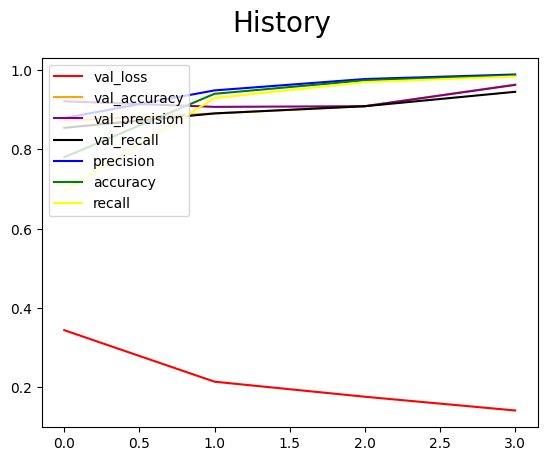

In [11]:
fig = plt.figure()
plt.plot(model_history.history["val_loss"], color='red', label="val_loss")
plt.plot(model_history.history["val_accuracy"], color='orange', label="val_accuracy")
plt.plot(model_history.history["val_precision"], color='purple', label="val_precision")
plt.plot(model_history.history["val_recall"], color='black', label="val_recall")
plt.plot(model_history.history["precision"], color='blue', label="precision")
plt.plot(model_history.history["accuracy"], color='green', label="accuracy")
plt.plot(model_history.history["recall"], color='yellow', label="recall")
fig.suptitle("History", fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
modell.save("MobileNet_model.h5")